# Netflix Insights - Explorative Data Analysis

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
netflix = pd.read_csv("data/netflix_titles.csv")
netflix.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


In [97]:
len(netflix)    #Dataset length

8807

#### What is the total number of movies and TV shows available on Netflix for each year?

In [98]:
total_num = netflix.copy()

#change 'date added' column from str to datetime
total_num["date_added"] = pd.to_datetime(total_num["date_added"], errors='coerce')
total_num.loc[:, "year_added"] = total_num["date_added"].dt.year.astype('Int64')

#seperated movies and tvshows 
movies_count = total_num.loc[total_num["type"] == "Movie"]
tvshows_count = total_num.loc[total_num["type"] == "TV Show"]

In [99]:
#How many movies and tv shows were added each year
combined_count = total_num.pivot_table(values="title", index="year_added", columns="type", aggfunc="count", fill_value=0)

In [100]:
combined_count

type,Movie,TV Show
year_added,,
2008,1,1
2009,2,0
2010,1,0
2011,13,0
2012,3,0
2013,6,4
2014,19,4
2015,56,17
2016,253,165


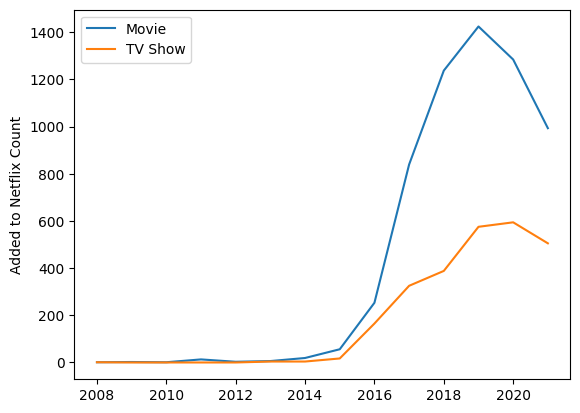

In [101]:
combined_count.plot(kind="line")
plt.ylabel("Added to Netflix Count")
plt.xlabel("")
plt.legend()
plt.show()

#### Which genres are the most popular on Netflix?

In [102]:
popular_genres = total_num.copy()
popular_genres.loc[:,"listed_in"].value_counts()

popular_genres["listed_in"] = popular_genres["listed_in"].apply(lambda x: x.split(", ")) #popular_genres.explode("listed_in")

In [103]:
popular_genres_exploded = popular_genres.explode("listed_in")

In [104]:
genre_counts = popular_genres_exploded["listed_in"].value_counts().head(10).sort_values(ascending=True)
genre_counts

listed_in
Romantic Movies              616
Children & Family Movies     641
Independent Movies           756
TV Dramas                    763
Action & Adventure           859
Documentaries                869
International TV Shows      1351
Comedies                    1674
Dramas                      2427
International Movies        2752
Name: count, dtype: int64

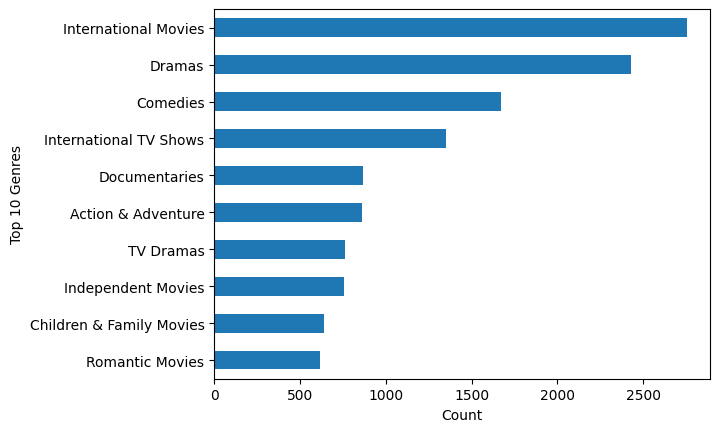

In [105]:
genre_counts.plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Top 10 Genres")
plt.show()

#### What is the average runtime of movies by genre?

In [106]:
#average duration for movies
avg_runtime = popular_genres_exploded.copy()
avg_runtime = avg_runtime.loc[avg_runtime["type"] == "Movie", :]
avg_runtime["duration"].isnull().sum()
avg_runtime = avg_runtime.dropna(subset=['duration'])   #drop null rows

In [107]:
#extract only number from duration
avg_runtime["duration"] = avg_runtime["duration"].astype(str).str.extract(r"(\d+)", expand=False).astype(float)

In [108]:
mean_movie_duration = avg_runtime.pivot_table(values="duration", index="listed_in", aggfunc="mean")
mean_movie_duration = mean_movie_duration.sort_values(by="duration", ascending=True)
mean_movie_duration

,duration
listed_in,
Movies,45.481481
Stand-Up Comedy,67.326531
Children & Family Movies,79.936037
Documentaries,81.630610
Anime Features,92.943662
LGBTQ Movies,94.294118
Sports Movies,94.698630
Horror Movies,98.445378
Independent Movies,101.051587


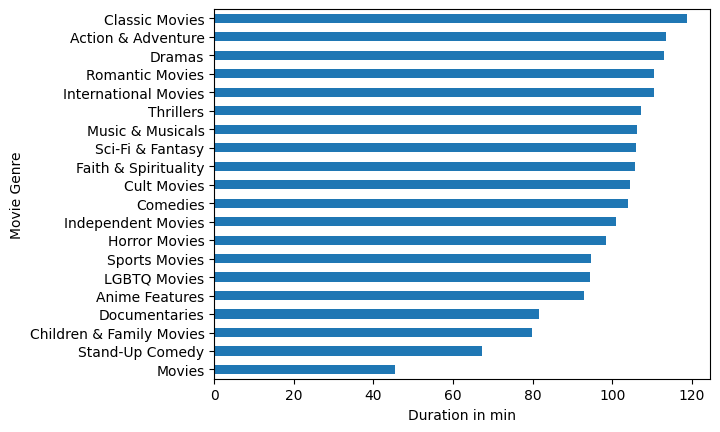

In [109]:
mean_movie_duration.plot(kind="barh", legend=False)
plt.xlabel("Duration in min")
plt.ylabel("Movie Genre")
plt.show()

#### Comparison of restricted content by countries: R, NC-17, TV-14, TV-MA
- R = Restricted, NC-17 = No One 17 and Under Admitted 
- TV-14 =  Not suitable for children under 14, TV-MA = Mature audiences only

In [110]:
top_rated = avg_runtime.copy()
average_runtime_by_rating = top_rated.groupby('rating')['country'].count()
print(average_runtime_by_rating)

rating
G             73
NC-17          7
NR           154
PG           598
PG-13        981
R           1560
TV-14       3181
TV-G         229
TV-MA       4163
TV-PG       1125
TV-Y         115
TV-Y7        126
TV-Y7-FV       8
UR             8
Name: country, dtype: int64


In [111]:
ratings_by_countries = top_rated.loc[:, ["title", "country", "rating"]]
ratings_by_countries = ratings_by_countries.dropna()
ratings_by_countries["country"] = ratings_by_countries["country"].apply(lambda x: x.split(", "))

ratings_by_countries = ratings_by_countries.explode("country")
ratings_by_countries
ratings_by_countries["country"].value_counts()

country
United States     5015
India             2606
United Kingdom    1065
France             726
Canada             633
                  ... 
Botswana             1
Kazakhstan           1
Somalia              1
Sudan                1
Uganda               1
Name: count, Length: 122, dtype: int64

In [112]:
#show amount of titles for type of rating by country
ratings_plot = ratings_by_countries.pivot_table(values="title", columns="rating", index="country", aggfunc="count")

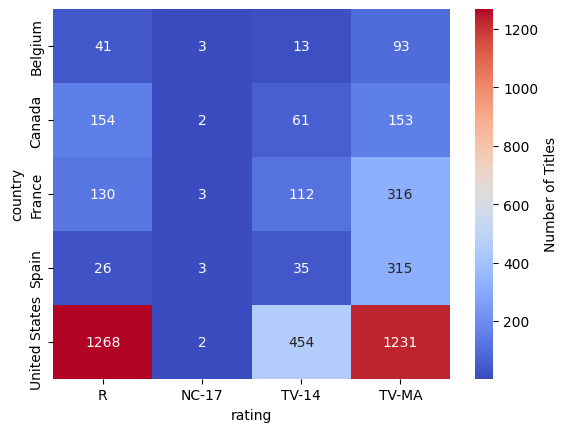

In [113]:
import seaborn as sns
#Heatmap - 5 countries in comparison to amount of rating
chosen_countries = ratings_plot.dropna(subset=["R", "NC-17", "TV-14", "TV-MA"])
chosen_countries
#usa_ratings = chosen_countries[chosen_countries.index == "United States"].loc[:, ["R"]]
chosen_countries = chosen_countries.loc[:, ["R", "NC-17", "TV-14", "TV-MA"]]
sns.heatmap(chosen_countries, annot=True,fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'Number of Titles'})
plt.show()

#### Alternative: including rating PG-13 (Parents Strongly Cautioned) & TV-PG (Parental guidance suggested)
- Zero Values included

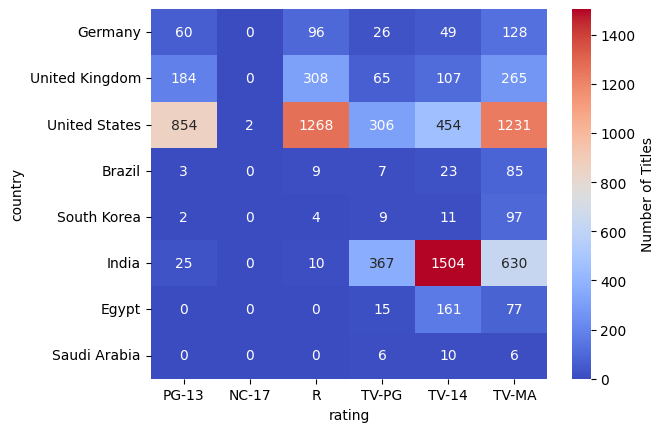

In [114]:
#Alternative with 0 values
chosen_countries2 = ratings_plot.fillna(0)
countries_list = ["Germany", "United Kingdom", "United States", "Brazil", "South Korea", "India", "Egypt", "Saudi Arabia"]
ratings_list = ["PG-13", "NC-17", "R", "TV-PG", "TV-14", "TV-MA"]
chosen_countries2 = chosen_countries2.loc[countries_list, ratings_list]
sns.heatmap(chosen_countries2, annot=True,fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'Number of Titles'})
plt.show()

In [115]:
actors_df = total_num.copy()
actors_df.dropna(subset=["cast"], inplace=True) #remove NaN cast columns

In [116]:
actors_df["cast"] = actors_df["cast"].apply(lambda x: x.split(", "))

In [126]:
actors_df = actors_df.explode("cast")
top_actors = actors_df["cast"].value_counts().head(10).sort_values(ascending=True)

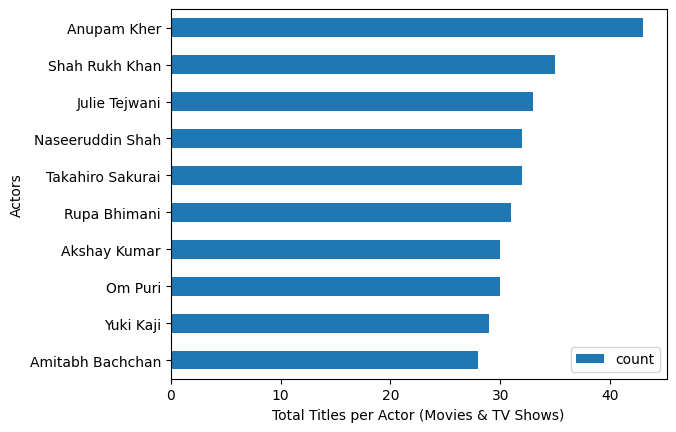

In [129]:
top_actors.plot(kind="barh")
plt.ylabel("Actors")
plt.xlabel("Total Titles per Actor (Movies & TV Shows)")
plt.legend()
plt.show()